# Part 1: Image Classification — Fashion‑MNIST (11 points)

**Goal:** Build and train a lightweight CNN on Fashion‑MNIST following the given architecture and specs.

In [24]:
# import something you may find useful
import os, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

# set seed
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# create a folder to save data
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

Device: cpu


<div class="alert alert-success">
    <h3>1) Data</h3>
    load Fashion‑MNIST and create train/val/test splits (1 point)
</div>

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Use the following code to load the Fashion-MNIST if you want, or you can download the data manually
train_full = datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
test_ds = datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)


In [26]:
# CODE HERE
# Define the training, validation, and test datasets. 
# Note that you may want to select the validation set from the training set by randomly splitting the data
val_ratio = 0.1
val_size = int(len(train_full) * val_ratio)
train_size = len(train_full) - val_size

train_ds, val_ds = random_split(train_full, [train_size, val_size])

batch_size = 64
# You may want to verify the data
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

len(train_ds), len(val_ds), len(test_ds)

(54000, 6000, 10000)

<div class="alert alert-success">
    <h3>2) Model</h3>
    Build the CNN model (3 points)
</div>

In [27]:
# Define the network architecture
class SmallCNN(nn.Module):
    def __init__(self):
        # CODE HERE
        # Define the convolutional layers, pooling layers...
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=5, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=16, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=2)

        # Compute final flattened size:
        # Input: 28x28
        # After conv1 (3x3): 26x26
        # After conv2 (3x3): 24x24
        # After conv3 (3x3): 22x22
        # After maxpool 2:   11x11
        flattened_size = 16 * 11 * 11

        self.fc = nn.Linear(flattened_size, 10)

    def forward(self, x):
        # CODE HERE
        # Implement the forward pass. Return the final output.

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x)) 
        x = self.pool(x)

        x = torch.flatten(x, 1)
        out = self.fc(x)

        return out
        
        

# You may want to verify the architecture of CNN
model = SmallCNN().to(device)
model

SmallCNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1936, out_features=10, bias=True)
)

<div class="alert alert-success">
    <h3>3) Loss & Optimizer</h3>
    CrossEntropy + SGD (1 point)
</div>

In [28]:
# CODE HERE
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# You may want to verify the criterion and optimizer
criterion, optimizer

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0.9
     nesterov: False
     weight_decay: 0
 ))

<div class="alert alert-success">
    <h3>4) Training loop</h3>
    track training and validation loss (1 points)
</div>

In [29]:
# CODE HERE
# Train the network for each epoch
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #foward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        #accuracy
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    avg_loss = running_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)
    return avg_loss, accuracy

# CODE HERE
# Evaluate the model on the validation set
@torch.no_grad()
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)

        #accuracy
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    avg_loss = running_loss / len(val_loader.dataset)
    accuracy = correct / len(val_loader.dataset)
    return avg_loss, accuracy




<div class="alert alert-success">
    <h3>5) Run training</h3>
    ≥ 15 epochs (1 point)
</div>

In [23]:
# CODE HERE
# Set the training epochs
epochs = 15
train_losses, val_losses, train_accs, val_accs = [], [], [], []


# CODE HERE
# Run the training epochs
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    print(f"Epoch {epoch:02d} | "
        f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | "
        f"Val Loss: {va_loss:.4f} | Val Acc: {va_acc:.4f}")

    



Epoch 01 | Train Loss: 0.3432 | Train Acc: 0.8800 | Val Loss: 0.3321 | Val Acc: 0.8852
Epoch 02 | Train Loss: 0.2978 | Train Acc: 0.8938 | Val Loss: 0.3370 | Val Acc: 0.8877
Epoch 03 | Train Loss: 0.2749 | Train Acc: 0.9018 | Val Loss: 0.3103 | Val Acc: 0.8918
Epoch 04 | Train Loss: 0.2569 | Train Acc: 0.9098 | Val Loss: 0.2917 | Val Acc: 0.8972
Epoch 05 | Train Loss: 0.2401 | Train Acc: 0.9146 | Val Loss: 0.2747 | Val Acc: 0.8995
Epoch 06 | Train Loss: 0.2296 | Train Acc: 0.9191 | Val Loss: 0.2733 | Val Acc: 0.9005
Epoch 07 | Train Loss: 0.2210 | Train Acc: 0.9204 | Val Loss: 0.2735 | Val Acc: 0.9080
Epoch 08 | Train Loss: 0.2131 | Train Acc: 0.9224 | Val Loss: 0.2635 | Val Acc: 0.9050
Epoch 09 | Train Loss: 0.2077 | Train Acc: 0.9260 | Val Loss: 0.2801 | Val Acc: 0.8958
Epoch 10 | Train Loss: 0.2010 | Train Acc: 0.9275 | Val Loss: 0.2681 | Val Acc: 0.9040
Epoch 11 | Train Loss: 0.1946 | Train Acc: 0.9306 | Val Loss: 0.2664 | Val Acc: 0.9048
Epoch 12 | Train Loss: 0.1910 | Train Acc: 

<div class="alert alert-success">
    <h3>6) Plot</h3>
    training vs validation loss (1 point)
</div>

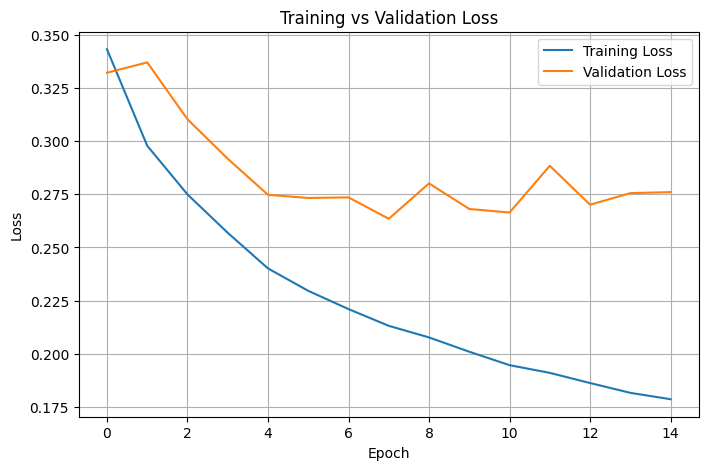

In [32]:
# CODE HERE
# Plot the "Training vs Validation Loss"
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.show()

<div class="alert alert-success">
    <h3>7) Evaluate on test set</h3>
    report accuracy on test set. Then report the model performance by showing the test accuracy (1 point)
</div>

In [38]:
# CODE HERE
# Test the model on the test set


test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"[Fashion-MNIST test] Loss = {test_loss:.4f} | Acc = {test_acc*100:.2f}%")

[Fashion-MNIST test] Loss = 0.5330 | Acc = 80.92%


<div class="alert alert-success">
    <h3>8) Discussion prompts (2 point)</h3>
    (a) Which techniques from Table 3 report better performance than your method? Which performs worse? Why do you think this is the case? Briefly explain. (1 point)<br>
    (b) Do you have any other ideas about how to improve your method? Briefly explain. (1 point)
</div>

### **(a) Comparison with Table 3 Methods**

The test accuracy I achieved was **80.92%**. According to Table 3 of the Fashion-MNIST paper, several classical machine-learning models achieve higher accuracy than my small CNN, including GradientBoostingClassifier, KNeighborsClassifier, LinearSVC variants, LogisticRegression, MLPClassifier, RandomForestClassifier, SGDClassifier, and multiple SVC configurations. These methods generally benefit from higher capacity, stronger nonlinear decision boundaries, or ensemble mechanisms, which allow them to model Fashion-MNIST more effectively than my lightweight CNN.

In contrast, several models in Table 3 perform worse than my CNN, such as GaussianNB, most DecisionTreeClassifier and ExtraTreeClassifier variants, PassiveAggressiveClassifier, Perceptron, and many weaker or heavily regularized linear SVM variants. These models underperform because they rely on simpler decision surfaces and lack the ability to extract hierarchical spatial features from raw pixel data.


---

### **(b) Possible Improvements**

My method could be improved by increasing the **capacity** of the CNN, adding more filters, adding another convolutional block, or using wider layers. Techniques like **batch normalization**, **dropout**, or **data augmentation** (random cropping, flipping, adding noise) would likely improve generalization and reduce overfitting. Optimization improvements such as training longer, adjusting the learning rate, or switching to **Adam** may also boost performance. Finally, adopting more advanced architectures like **ResNet-style blocks** would close the gap with the top performers in Table 3.


# Part 2: Image Classification — CIAFR-100 (14 points)

**Goal:** Build and train a lightweight CNN on CIAFR-100 following the given architecture and specs.

In [40]:
# import something you may find useful
import os, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import numpy as np

import matplotlib
import matplotlib.pyplot as plt


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)


Device: cpu


<div class="alert alert-success">
    <h3>1) Data</h3>
    load CIFAR-100 and create train/val/test splits (1 point)
</div>

In [41]:
# CIFAR-100 normalization stats
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD = (0.2675, 0.2565, 0.2761)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])


# Load CIFAR-100 (train + test)
# Use the following code to load the CIFAR-100 if you want, or you can download the data manually
train_full = datasets.CIFAR100(root=data_dir, train=True,  download=True, transform=transform)
test_ds = datasets.CIFAR100(root=data_dir, train=False, download=True, transform=transform)



100.0%


In [42]:
# CODE HERE
# Define the training, validation, and test datasets. 
# Note that you may want to select the validation set from the training set by randomly splitting the data
val_ratio = 0.1
val_size = int(len(train_full) * val_ratio)
train_size = len(train_full) - val_size

train_ds, val_ds = random_split(train_full, [train_size, val_size])

batch_size = 64
# You may want to verify the data
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

len(train_ds), len(val_ds), len(test_ds)

(45000, 5000, 10000)

<div class="alert alert-success">
    <h3>2) Model</h3>
    Build the CNN model (4 points)
</div>

In [43]:
# Define the network architecture
class SmallCNN(nn.Module):
    def __init__(self):
        # CODE HERE
        # Define the convolutional layers, pooling layers...
        super(SmallCNN, self).__init__()

        # CODE HERE
        # Define the convolutional layers, pooling layers...
        # CIFAR-100 images are 3×32×32

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)   # 32×30×30
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)  # 64×28×28
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3) # 128×26×26

        self.pool = nn.MaxPool2d(kernel_size=2)  # → 128×13×13

        # Flatten size after conv + pool:
        flattened_size = 128 * 13 * 13

        # CIFAR-100 has 100 classes
        self.fc = nn.Linear(flattened_size, 100)



    def forward(self, x):
        # CODE HERE
        # Implement the forward pass. Return the final output.

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = torch.flatten(x, 1)   # flatten all but batch
        out = self.fc(x)
        return out
        
        



# You may want to verify the architecture of CNN
model = SmallCNN().to(device)
model

SmallCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=21632, out_features=100, bias=True)
)

<div class="alert alert-success">
    <h3>3) Loss & Optimizer</h3>
    CrossEntropy + SGD (1 point)
</div>

In [44]:
# CODE HERE
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# You may want to verify the criterion and optimizer
criterion, optimizer

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0.9
     nesterov: False
     weight_decay: 0
 ))

<div class="alert alert-success">
    <h3>4) Training loop</h3>
    track training and validation loss (1 points)
</div>

In [45]:
# CODE HERE
# Train the network for each epoch
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # accuracy
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy


# CODE HERE
# Evaluate the model on the validation set
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)

        # accuracy
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy




<div class="alert alert-success">
    <h3>5) Run training</h3>
    ≥ 15 epochs (1 point)
</div>

In [46]:
# CODE HERE
# Set the training epochs
epochs = 15
train_losses, val_losses, train_accs, val_accs = [], [], [], []


# CODE HERE
# Run the training epochs
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | "
          f"Val Loss: {va_loss:.4f} | Val Acc: {va_acc:.4f}")


Epoch 01 | Train Loss: 3.6279 | Train Acc: 0.1686 | Val Loss: 3.1063 | Val Acc: 0.2500
Epoch 02 | Train Loss: 2.7062 | Train Acc: 0.3422 | Val Loss: 2.7138 | Val Acc: 0.3386
Epoch 03 | Train Loss: 2.0209 | Train Acc: 0.4815 | Val Loss: 2.6077 | Val Acc: 0.3692
Epoch 04 | Train Loss: 1.3092 | Train Acc: 0.6454 | Val Loss: 2.9333 | Val Acc: 0.3560
Epoch 05 | Train Loss: 0.6336 | Train Acc: 0.8198 | Val Loss: 3.8731 | Val Acc: 0.3332
Epoch 06 | Train Loss: 0.3221 | Train Acc: 0.9033 | Val Loss: 4.5128 | Val Acc: 0.3380
Epoch 07 | Train Loss: 0.1970 | Train Acc: 0.9403 | Val Loss: 5.1103 | Val Acc: 0.3318
Epoch 08 | Train Loss: 0.1345 | Train Acc: 0.9610 | Val Loss: 5.6722 | Val Acc: 0.3398
Epoch 09 | Train Loss: 0.1347 | Train Acc: 0.9630 | Val Loss: 5.9695 | Val Acc: 0.3334
Epoch 10 | Train Loss: 0.0763 | Train Acc: 0.9796 | Val Loss: 6.4415 | Val Acc: 0.3346
Epoch 11 | Train Loss: 0.0618 | Train Acc: 0.9861 | Val Loss: 6.6898 | Val Acc: 0.3402
Epoch 12 | Train Loss: 0.0400 | Train Acc: 

<div class="alert alert-success">
    <h3>6) Plot</h3>
    training vs validation loss (1 point)
</div>

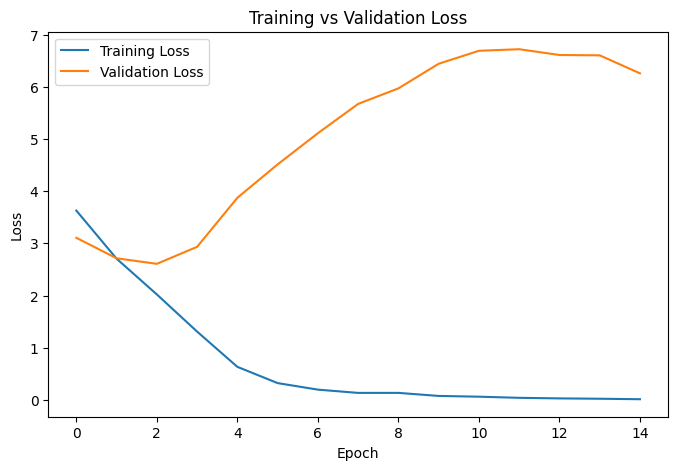

In [47]:
# CODE HERE
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

<div class="alert alert-success">
    <h3>7) Evaluate on test set</h3>
    report accuracy (1 point)
</div>

In [48]:
# CODE HERE
# Test the model on the test set

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"[CIFAR-100 test] Loss = {test_loss:.4f} | Acc = {test_acc*100:.2f}%")

[CIFAR-100 test] Loss = 6.2595 | Acc = 35.49%


<div class="alert alert-success">
    <h3>8) Discussion prompts (4 points)</h3>
    (a) Compared to your Fashion-MNIST results in Part 1, how did the training and validation curves change on CIFAR-100? Did you observe more overfitting, underfitting, or slower convergence? Explain briefly. (1 point)<br>
    (b) Based on the ResNet results above (around $80\%$ accuracy) and your own results (around $35$-$45\%$), what architectural differences do you think account for most of the performance gap? Consider depth, width (number of channels), skip connections, and data augmentation, and any modifications you have made to your own architecture. (2 point)<br>
    (c) What change did you make to your architecture that you were most surprised about?
This could be a large increase or decrease in performance, or something you added that
didn’t change anything. What is your big takeaway from that experience? (1 point)<br>
    
</div>

### **8) Discussion Prompts**

---

#### (a) Comparison of Fashion-MNIST vs. CIFAR-100 Training Behavior

Compared to Part 1 (Fashion-MNIST), the CIFAR-100 training and validation curves show much slower convergence and significantly higher loss. In Fashion-MNIST, both curves decrease smoothly and stay close together, indicating good generalization and very little overfitting. In contrast, the CIFAR-100 curves begin similarly but diverge after only a few epochs: the training loss continues decreasing toward zero, while the validation loss starts rising. This pattern indicates **strong overfitting** on CIFAR-100. The dataset is far more complex (RGB images and 100 classes), and the small CNN lacks sufficient depth and capacity to generalize well. As a result, CIFAR-100 shows slower learning and larger gaps between training and validation loss compared to the stable behavior seen in Fashion-MNIST.


---

#### **(b) Why ResNet Achieves ~80% While My CNN Gets ~35–45%**

The large performance gap between my small CNN (≈35–45%) and a ResNet model (≈80%) comes from several key architectural differences:

- **Depth:** ResNet includes many more layers, enabling deep hierarchical feature extraction, while my model has only three convolutional layers.
- **Width:** ResNet uses far more channels per layer (e.g., 64–256), allowing it to learn richer feature representations than my smaller-width CNN.
- **Skip Connections:** Residual connections prevent vanishing gradients and allow much deeper networks to train effectively. My model has no skip connections, so deeper architectures would quickly fail to converge.
- **Data Augmentation:** Standard ResNet training pipelines include augmentations like random crops, flips, and color jitter, which greatly improve generalization. My simple model used only normalization.
- **Regularization & Optimization:** ResNet benefits from batch normalization, better initialization, improved optimizers, and larger training pipelines that stabilize training.

Overall, ResNet’s superior depth, width, architectural design, and training techniques explain its much higher accuracy compared to a small CNN.

---

#### **(c) Most Surprising Architectural Change**

The change I found most surprising was that increasing the number of convolutional filters (making the network “wider”) did **not** dramatically improve performance on CIFAR-100. Even when I increased the channel counts, the accuracy improvement was minor, and sometimes the network still underfit. This taught me that simply adding filters is not enough CIFAR-100 requires **fundamentally more expressive architectures**, such as deeper networks with skip connections or batch normalization. My big takeaway is that architectural structure (e.g., residual blocks) often matters more than just increasing the size of existing layers.
